# Linear Regression Implementation from Scratch

We will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer

In [1]:
%matplotlib inline
import random

import torch

from d2l import torch as d2l


We will construct an artificial dataset
according to a linear model with additive noise.
The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.6446, 0.4791]) 
label: tensor([3.8596])


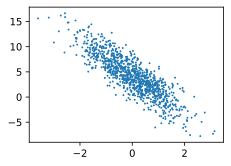

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1)

We define the `data_iter` function
that
takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3434,  1.0325],
        [-0.8486,  0.0309],
        [-0.6333,  0.2750],
        [-0.4983, -1.7182],
        [ 0.4706, -0.6825],
        [-0.6200,  0.2357],
        [ 1.0307, -0.4293],
        [-0.9141,  0.3708],
        [-1.9753, -0.2624],
        [ 0.1597, -0.4702]]) 
 tensor([[4.6197e-05],
        [2.4225e+00],
        [1.9909e+00],
        [9.0585e+00],
        [7.4607e+00],
        [2.1542e+00],
        [7.7313e+00],
        [1.1068e+00],
        [1.1490e+00],
        [6.1159e+00]])


Before we can begin optimizing our model's parameters by minibatch stochastic gradient descent,
we need to have some parameters in the first place

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

Next, we must define our model,
relating its inputs and parameters to its outputs

In [9]:
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

Since updating our model requires taking
the gradient of our loss function,
we ought to define the loss function first

In [10]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

Linear regression has a closed-form solution.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of
minibatch stochastic gradient descent

In [11]:
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

Now
we are ready to implement the main training loop

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035217
epoch 2, loss 0.000130
epoch 3, loss 0.000052


We can evaluate our success in training
by comparing the true parameters
with those that we learned through our training loop

In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-0.0001, -0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0002], grad_fn=<RsubBackward1>)
